# Skin Cancer Image Processing and Baseline Model

In [1]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

In [2]:
# Define modeling results display function:
def visualize_modeling_results(results):
    '''   
    Input: keras model history results
    '''
    history = results.history
    
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['train', 'validation'], loc='lower left')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [3]:
!ls ../data

Additional_malignant
ISIC_2019_512x512
ISIC_2019_512x512.csv
ISIC_2019_Training_GroundTruth.csv
ISIC_2019_Training_Input
ISIC_2019_Training_Metadata.csv
ISIC_2020_Training_GroundTruth.csv
ISIC_2020_Training_JPEG
ISIC_FINAL_DATASET.csv
ISIC_FINAL_DATASET_512x512.csv
ISIC_IMAGES_512x512
add_train_malig_2.csv


In [4]:
# Reading in the final dataset from Data_Exploration.ipynb
df = pd.read_csv('../data/ISIC_FINAL_DATASET_512x512.csv')
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38223,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
38224,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
38225,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
38226,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg


- All images in the final dataset has size of 512x512.

In [5]:
df['benign_malignant'].value_counts()

benign       32542
malignant     5686
Name: benign_malignant, dtype: int64

In [6]:
df['target'].value_counts()

0    32542
1     5686
Name: target, dtype: int64

In [7]:
# Define X and y 
X = df[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df['benign_malignant']

In [8]:
X

,image_name,path,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,head/neck
1,ISIC_0015719,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,upper extremity
2,ISIC_0052212,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,50.0,lower extremity
3,ISIC_0068279,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,head/neck
4,ISIC_0074268,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,upper extremity
...,...,...,...,...,...
38223,ISIC_0024302,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,female,25.0,NaN
38224,ISIC_0024303,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,60.0,NaN
38225,ISIC_0024304,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,70.0,NaN
38226,ISIC_0024305,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,85.0,NaN


In [9]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
# Train - Validation set Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# Train dataframe
df_train = pd.concat([X_train, y_train], axis=1)
print(f"Train dataset: \n {df_train['benign_malignant'].value_counts()}")
df_train

Train dataset: 
 benign       23466
malignant     4058
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
24359,ISIC_7393413,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
10998,ISIC_3392311,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
14078,ISIC_4319874,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
16697,ISIC_5106902,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,20.0,upper extremity,benign
13819,ISIC_4241907,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,60.0,NaN,benign
...,...,...,...,...,...,...
31284,ISIC_9454024,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,lower extremity,benign
21812,ISIC_6604551,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,NaN,benign
29,ISIC_0085172,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,50.0,lower extremity,benign
8476,ISIC_2644988,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,55.0,torso,benign


In [12]:
# Validation dataframe
df_val = pd.concat([X_val, y_val], axis=1)
print(f"Test dataset: \n {df_val['benign_malignant'].value_counts()}")
df_val

Test dataset: 
 benign       5842
malignant    1039
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
32071,ISIC_9688534,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,lower extremity,benign
966,ISIC_0397464,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,70.0,upper extremity,benign
6842,ISIC_2144220,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,40.0,lower extremity,benign
21536,ISIC_6534818,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,70.0,lower extremity,benign
18511,ISIC_5623668,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,lower extremity,benign
...,...,...,...,...,...,...
37377,ISIC_0071388,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,70.0,head/neck,malignant
10173,ISIC_3152541,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,30.0,lower extremity,benign
14232,ISIC_4363603,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,head/neck,benign
33104,ISIC_9994390,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,65.0,lower extremity,benign


In [13]:
# Test (Holdout) dataframe:
df_test = pd.concat([X_test, y_test], axis=1)
print(f"Test dataset: \n {df_test['benign_malignant'].value_counts()}")
df_test

Test dataset: 
 benign       3234
malignant     589
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
10115,ISIC_3135594,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,65.0,torso,benign
13314,ISIC_4087028,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,50.0,upper extremity,benign
198,ISIC_0177860,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,35.0,torso,benign
12365,ISIC_3805310,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,lower extremity,benign
4689,ISIC_1506954,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,30.0,lower extremity,benign
...,...,...,...,...,...,...
22755,ISIC_6912233,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,torso,benign
7528,ISIC_2354682,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,lower extremity,benign
22188,ISIC_6718737,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,70.0,head/neck,benign
36229,ISIC_0063109,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,80.0,head/neck,malignant


## Image Preprocessing for Modeling

In [14]:
# Instantiating a generator object and normalizing the RGB values:
generator = ImageDataGenerator(rescale=1./255)


# Creating the generator for the training data
train_generator = generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 256x256
                                                target_size=(256, 256),
                                                seed=42,
                                                batch_size= int(len(df_train)/3),
                                                class_mode='binary')


# Creating the generator for the validation data
val_generator = generator.flow_from_dataframe(df_val, x_col='path', y_col='benign_malignant',
                                              # Re-sizing images to 256x256
                                              target_size=(256, 256),
                                              seed=42,
                                              batch_size= int(len(df_val)/3),
                                              class_mode='binary')


# Setting aside a testing/hold-out set
test_generator =  generator.flow_from_dataframe(df_test, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 256x256
                                                target_size=(256, 256),
                                                seed=42,
                                                batch_size= int(len(df_test)/3),
                                                class_mode='binary')

Found 27524 validated image filenames belonging to 2 classes.
Found 6881 validated image filenames belonging to 2 classes.
Found 3823 validated image filenames belonging to 2 classes.


In [15]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [16]:
# Create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

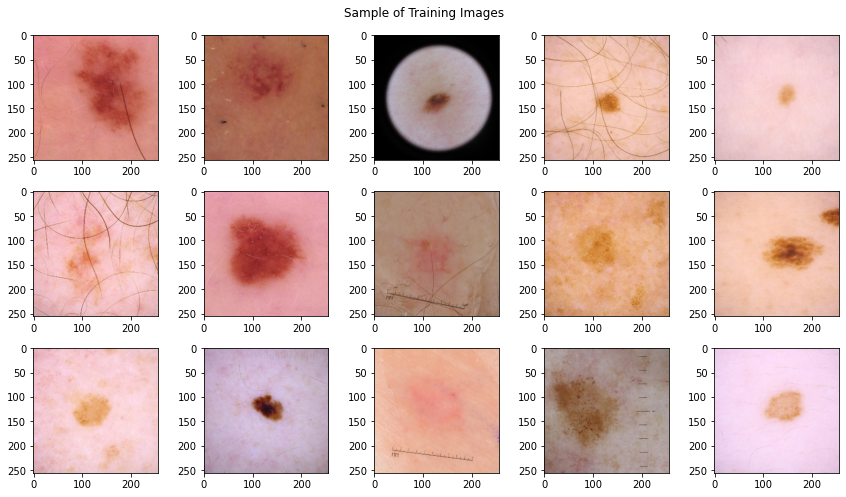

In [17]:
# Visualize Training images sample
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
for i in range(15):
    img = train_images[i]
    ax = axes[i//5, i%5]
    ax.imshow(img)
fig.suptitle('Sample of Training Images')
plt.tight_layout()
plt.show()

In [18]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Validation data set classes, {val_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Validation data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}


In [19]:
# Explore dataset again
m_train = train_images.shape[0]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of test samples: " + str(m_test))

print ("train_images shape: " + str(train_images.shape))   # batch_size=int(len(df_tr)/3) --> 27524/3 = 9174
print ("train_labels shape: " + str(train_labels.shape))

print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 9174
Number of validation samples: 2293
Number of test samples: 1274
train_images shape: (9174, 256, 256, 3)
train_labels shape: (9174,)
val_images shape: (2293, 256, 256, 3)
val_labels shape: (2293,)
test_images shape: (1274, 256, 256, 3)
test_labels shape: (1274,)


In [20]:
# Reshaping image sets:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(9174, 196608)
(2293, 196608)
(1274, 196608)


In [21]:
# Reshaping label sets:
train_y = np.reshape(train_labels, (train_img.shape[0], 1))
val_y = np.reshape(val_labels, (val_img.shape[0], 1))
test_y = np.reshape(test_labels, (test_img.shape[0], 1))

print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(9174, 1)
(2293, 1)
(1274, 1)


## Modeling with Neural Networks

### Step 1: Baseline Model - Multi-Layer Perceptron

In [22]:
# Fit a Neural Network Model
model = models.Sequential()

# Adding layers
model.add(layers.Dense(20, activation='relu', input_shape=(train_img.shape[1],))) # input layer
model.add(layers.Dense(12, activation='relu'))   # hidden layer
model.add(layers.Dense(5, activation='relu'))    # hidden layer
model.add(layers.Dense(1, activation='sigmoid')) # output layer

In [23]:
# visalize model layers:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3932180   
_________________________________________________________________
dense_1 (Dense)              (None, 12)                252       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 65        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 3,932,503
Trainable params: 3,932,503
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile and fit the model:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

history = model.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(test_img, test_y))

Epoch 1/10
287/287 [==============================] - 13s 45ms/step - loss: 1.5074 - accuracy: 0.8470 - recall: 0.0083 - precision: 0.1146 - auc: 0.4984 - val_loss: 0.5039 - val_accuracy: 0.8462 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
287/287 [==============================] - 11s 37ms/step - loss: 0.4660 - accuracy: 0.8550 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.4912 - val_loss: 0.4543 - val_accuracy: 0.8462 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 3/10
287/287 [==============================] - 11s 38ms/step - loss: 0.4338 - accuracy: 0.8550 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.5061 - val_loss: 0.4382 - val_accuracy: 0.8462 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 4/10
287/287 [==============================] - 10s 35ms/step - loss: 0.4222 - accuracy: 0.8550 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.4997 - val_loss: 0.4324 - val_

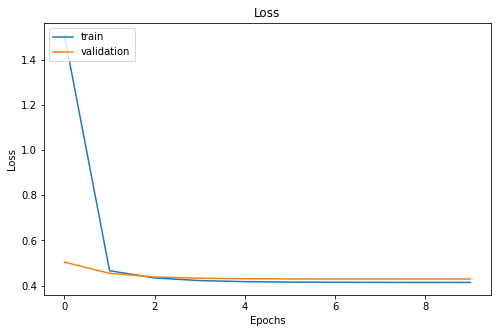

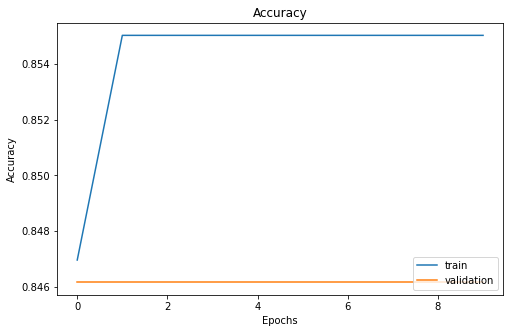

In [25]:
# Visualize the training results:
visualize_modeling_results(history)

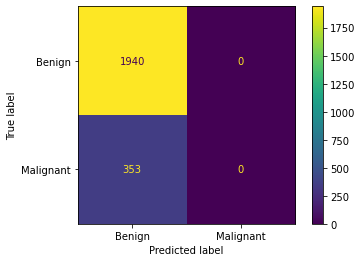

In [26]:
# Plot confusion matrix:
predictions = (model.predict(val_img) > 0.5).astype("int32")
cm = confusion_matrix(val_y, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot()
plt.show()

- We got 85% accuracy for training and 84% accuracy for validation set.

In [27]:
# Evaluatetrain and test set:
results_train = model.evaluate(train_img, train_y)
results_validation = model.evaluate(val_img, val_y)


# Construct a new dataframe to save results:
baseline_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    baseline_results[baseline_results.columns[i]]['Train'] = results_train[i]
    baseline_results[baseline_results.columns[i]]['Validation'] = results_validation[i]
    
baseline_results

72/72 [==============================] - 1s 15ms/step - loss: 0.4296 - accuracy: 0.8461 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.5000


,Loss,Accuracy,Recall,Precision,AUC
Train,0.413956,0.855025,0,0,0.5
Validation,0.42959,0.846053,0,0,0.5


### Step 2: Convolutional Neural Network

In [28]:
# Create the architecture of the model
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               31490176  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [29]:
# Compile and fit the model:
cnn_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

cnn_history = cnn_model.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(val_images, val_labels))

Epoch 1/10
459/458 [==============================] - 511s 1s/step - loss: 0.3368 - accuracy: 0.8652 - recall: 0.0857 - precision: 0.8444 - auc: 0.8027 - val_loss: 0.3700 - val_accuracy: 0.9067 - val_recall: 0.6034 - val_precision: 0.7422 - val_auc: 0.9171
Epoch 2/10
459/458 [==============================] - 556s 1s/step - loss: 0.2720 - accuracy: 0.8975 - recall: 0.3820 - precision: 0.8115 - auc: 0.8757 - val_loss: 0.2240 - val_accuracy: 0.9128 - val_recall: 0.4759 - val_precision: 0.9180 - val_auc: 0.9322
Epoch 3/10
459/458 [==============================] - 528s 1s/step - loss: 0.2297 - accuracy: 0.9154 - recall: 0.5316 - precision: 0.8221 - auc: 0.9095 - val_loss: 0.2148 - val_accuracy: 0.9154 - val_recall: 0.4674 - val_precision: 0.9649 - val_auc: 0.9440
Epoch 4/10
459/458 [==============================] - 500s 1s/step - loss: 0.2067 - accuracy: 0.9238 - recall: 0.5880 - precision: 0.8382 - auc: 0.9266 - val_loss: 0.2498 - val_accuracy: 0.9032 - val_recall: 0.8300 - val_precisio

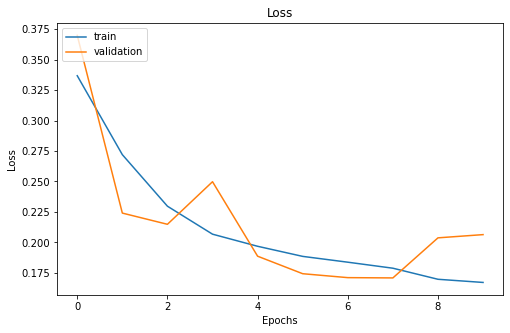

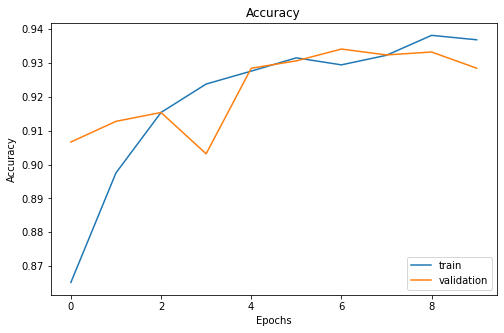

In [32]:
# Visualize the training results:
visualize_modeling_results(cnn_history)

In [ ]:
# Plot confusion matrix:
cnn_predictions = (cnn_model.predict_classes(val_generator) > 0.5).astype("int32")
cnn_cm = confusion_matrix(val_generator.classes, cnn_predictions)
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=['Benign', 'Malignant'])
cnn_disp.plot()
plt.show()

In [35]:
# Evaluatetrain and test set:
cnn_results_train = cnn_model.evaluate(train_images, train_labels)
cnn_results_validation = cnn_model.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
cnn_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    cnn_results[baseline_results.columns[i]]['Train'] = cnn_results_train[i]
    cnn_results[baseline_results.columns[i]]['Validation'] = cnn_results_validation[i]
    
cnn_results

72/72 [==============================] - 39s 540ms/step - loss: 0.2063 - accuracy: 0.9285 - recall: 0.5892 - precision: 0.9163 - auc: 0.9407


,Loss,Accuracy,Recall,Precision,AUC
Train,0.195036,0.932091,0.571429,0.934809,0.945484
Validation,0.206349,0.928478,0.589235,0.9163,0.940684
